# Customer Complaint Topic Modelling using LDA (Latent Direchlet Allocation)

## Introduction
Currently I am working as a business analyst in the banking industry in Australia. It is arguable that the number one priority for a consumer bank is to keep it's customers happy. As part of a running a business, complaints will naturally occur.

What could seperate a succesful business to a failing business is how each business handles complaints. 

# Problem Statement
The aim of this project is to gain a greater understanding of a corpus of customer complaints by answering the question: 

####  What are the hidden customer complaint topics?  

LDA (Latent Direchlet Allocation) will be used to answer this and hopefully provide a proof of concept to be implemented in a real life scenario.

Once hidden topics have been found, analysis of the keywords of these topics can now be analysed and provide further insights for the business to improve and action.

#### Objectives:
1. Preprocess customer complaint data, ready for ingestion of Machine Learning Models.
2. Create an LDA (Latent Direchlet Allocation) model to identify possible clusters of complaints into 'topics'
3. Analyse topics and obtain insights.

## Metrics
In order to select the best LDA model the following metric will be used

1. Coherence - Lower the better

I.e the best model will be the LDA model with the highest coherence value.

## Strategy
The following steps will be performed to complete this project and show the potential of using LDA:

1. Pre-process customer complaint data by tokenising, removing stop words the lemmatizing.
2. Explore data to produce initial insights.
3. Produce first pass base line assuming 8 latent topics.
4. Create multiple LDA models with a range of topic models, the best model will be chosen using the Coherence metric as discussed above.
5. Visualise clusters of complaints as predicted by the found LDA using T-SNE and SVD.
6. Analyse these found topics to obtain further insights within the customer complaint corpus.

## Dataset
The dataset being is used is a set of publicly available customer complaints for US company Comcast. This dataset was obtained from kaggle linked below https://www.kaggle.com/archaeocharlie/comcastcomplaints.


| Column Name | Description                                              |
|-------------|----------------------------------------------------------|
| author      | Author of the complaint which includes name and location |
| posted_on   | Date the complaint was posted                            |
| rating      | Rating of the complaint from 0-5                         |
| text        | The complaint in text                                    |



# Imports

In [47]:
import numpy as np
import pandas as pd
import spacy, nltk, pprint

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import gensim
from gensim.corpora import Dictionary

from sklearn.manifold import TSNE
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, save
from bokeh.models import ColumnDataSource
from bokeh.transform import cumsum
from bokeh.io import curdoc

from gensim.models import CoherenceModel, LdaModel
import pyLDAvis.gensim

from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

from nltk.probability import FreqDist

In [48]:
# read in dataset
ca_complaints_df = pd.read_csv('complaints/comcast_consumeraffairs_complaints.csv')
print(ca_complaints_df.shape)
ca_complaints_df.head()

(5659, 4)


,author,posted_on,rating,text
0,"Alantae of Chesterfeild, MI","Nov. 22, 2016",1,I used to love Comcast. Until all these consta...
1,"Vera of Philadelphia, PA","Nov. 19, 2016",1,I'm so over Comcast! The worst internet provid...
2,"Sarah of Rancho Cordova, CA","Nov. 17, 2016",1,If I could give them a negative star or no sta...
3,"Dennis of Manchester, NH","Nov. 16, 2016",1,I've had the worst experiences so far since in...
4,"Ryan of Bellevue, WA","Nov. 14, 2016",1,Check your contract when you sign up for Comca...


# Data Preprocessing

- Before any exploratory data analysis or modelling we must preprocess our text data.

## Proprocessing steps
1. Tokenization
2. Stop Word Removal
3. Lemmatization

In [49]:
# Convert text column to list
ca_complaints = ca_complaints_df['text'].tolist()  

#Show example of one complaint
ca_complaints[1]

"I'm so over Comcast! The worst internet provider. I'm taking online classes and multiple times was late with my assignments because of the power interruptions in my area that lead to poor quality internet service. Definitely switching to Verizon. I'd rather pay $10 extra then dealing w/ Comcast and non stopping internet problems."

In [50]:
def tokenize(complaints):
    '''
    This function will tokenise a corpus of complaints, removing punctuation
    
    Parameters:
    complaints: array of complaints
    
    returns:
    generator: 2d array of tokenized complaints
    '''
    for sentence in complaints:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True))
        
        
# obtain tokenized complaints
complaints_tokenized = list(tokenize(ca_complaints))


#pint example of tokenized complaint
print(complaints_tokenized[:2])

[['used', 'to', 'love', 'comcast', 'until', 'all', 'these', 'constant', 'updates', 'my', 'internet', 'and', 'cable', 'crash', 'lot', 'at', 'night', 'and', 'sometimes', 'during', 'the', 'day', 'some', 'channels', 'don', 'even', 'work', 'and', 'on', 'demand', 'sometimes', 'don', 'play', 'either', 'wish', 'they', 'will', 'do', 'something', 'about', 'it', 'because', 'just', 'few', 'mins', 'ago', 'the', 'internet', 'have', 'crashed', 'for', 'about', 'mins', 'for', 'no', 'reason', 'tired', 'of', 'it', 'and', 'thinking', 'about', 'switching', 'to', 'wow', 'or', 'something', 'please', 'do', 'not', 'get', 'xfinity'], ['so', 'over', 'comcast', 'the', 'worst', 'internet', 'provider', 'taking', 'online', 'classes', 'and', 'multiple', 'times', 'was', 'late', 'with', 'my', 'assignments', 'because', 'of', 'the', 'power', 'interruptions', 'in', 'my', 'area', 'that', 'lead', 'to', 'poor', 'quality', 'internet', 'service', 'definitely', 'switching', 'to', 'verizon', 'rather', 'pay', 'extra', 'then', 'de

In [51]:
#create spacy object for removing stop words
nlp = English()

def remove_stop_words(tokenized_complaints):
    '''
    This function will remove stop words from tokenized complaints
    
    Inputs:
    tokenized_complaints: 2d array of tokenized complaints
    
    Returns:
    filtered_complaints: 2d array of tokenized complaints with stop words removed
    '''
    
    #placeholder for the filtered complaints
    filtered_complaints = []
    
    #traverse through tokenized complaints
    for complaint in tokenized_complaints:
        
        #placeholder for each token
        filtered_complaint = []
        
        for word in complaint:
            lexeme = nlp.vocab[word]
            
            #check if the token is a stopword by referencing spacy's stop word list
            if lexeme.is_stop == False:
                filtered_complaint.append(word)
                
        filtered_complaints.append(filtered_complaint)
    
                
    return filtered_complaints

#remove stop words
stop_words_removed = remove_stop_words(complaints_tokenized)

#show example of tokenized complaint with stop words removed
stop_words_removed[0]

['love',
 'comcast',
 'constant',
 'updates',
 'internet',
 'cable',
 'crash',
 'lot',
 'night',
 'day',
 'channels',
 'don',
 'work',
 'demand',
 'don',
 'play',
 'wish',
 'mins',
 'ago',
 'internet',
 'crashed',
 'mins',
 'reason',
 'tired',
 'thinking',
 'switching',
 'wow',
 'xfinity']

In [52]:
#load the spacy core for lemmatizing
import en_core_web_sm
nlp = en_core_web_sm.load()

def lemmatization(complaints, postags = ['NOUN','ADJ','VERB','ADV']):
    '''
    The function will perform lemmatization on tokenized complaints
    
    Inputs:
    complaints: 2d array of tokenized complaints
    postags: part of speech tags to perform lemmatization on
    
    Returns
    complaints_out: lemmatized complaints
    '''
    
    #placeholder
    complaints_out = []
    
    for complaint in complaints:
        
        #rejoin complaints into single sentance
        doc = nlp(" ".join(complaint))
        
        #only obtain tokens who have been id'd as a postag as per postags and not '-PRON-'
        complaints_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                                        for token in doc if token.pos_ in postags]))
    
    return complaints_out

#perform lemmatization
complaints_lemmatized = lemmatization(stop_words_removed)


print(complaints_lemmatized[:2])

['love constant update internet cable crash lot night channel demand wish min ago internet crash min reason tired thinking switching xfinity', 'comcast bad internet provider take online class multiple time late assignment power interruption area lead poor quality internet service definitely switch pay extra deal comcast non stop internet problem']


# Data Exploration

Now that data has been preprocessed we can now explore the data and draw some initial insights.

Since the main problem we are trying to solve involves looking for topics lets explore the following features.

1. Number of complaints - Over Time
2. Rating Distribution - Over Time
3. Top Keywords across all complaints
4. Complaint Length Distribution


In [53]:
#Number of complaints
num_complaints = len(ca_complaints)

print(f'The total number of complaints is: {num_complaints}')

The total number of complaints is: 5659


In [54]:
#preprocess data column to datetime
ca_complaints_df['posted_on'] = ca_complaints_df['posted_on'].str.replace('[^\\w\\s]','')

#standardise month names
ca_complaints_df['posted_on'] = ca_complaints_df['posted_on'].replace({'Sept': 'Sep',
                                                                       'July': 'Jul',
                                                                       'June': 'Jun',
                                                                      'April':'Apr',
                                                                      'March':'Mar'}, regex=True)

#create column with complaint date in datetime format
ca_complaints_df['complaint_date'] = pd.to_datetime(ca_complaints_df['posted_on'], format='%b %d %Y')


ca_complaints_df.head()

,author,posted_on,rating,text,complaint_date
0,"Alantae of Chesterfeild, MI",Nov 22 2016,1,I used to love Comcast. Until all these consta...,2016-11-22
1,"Vera of Philadelphia, PA",Nov 19 2016,1,I'm so over Comcast! The worst internet provid...,2016-11-19
2,"Sarah of Rancho Cordova, CA",Nov 17 2016,1,If I could give them a negative star or no sta...,2016-11-17
3,"Dennis of Manchester, NH",Nov 16 2016,1,I've had the worst experiences so far since in...,2016-11-16
4,"Ryan of Bellevue, WA",Nov 14 2016,1,Check your contract when you sign up for Comca...,2016-11-14


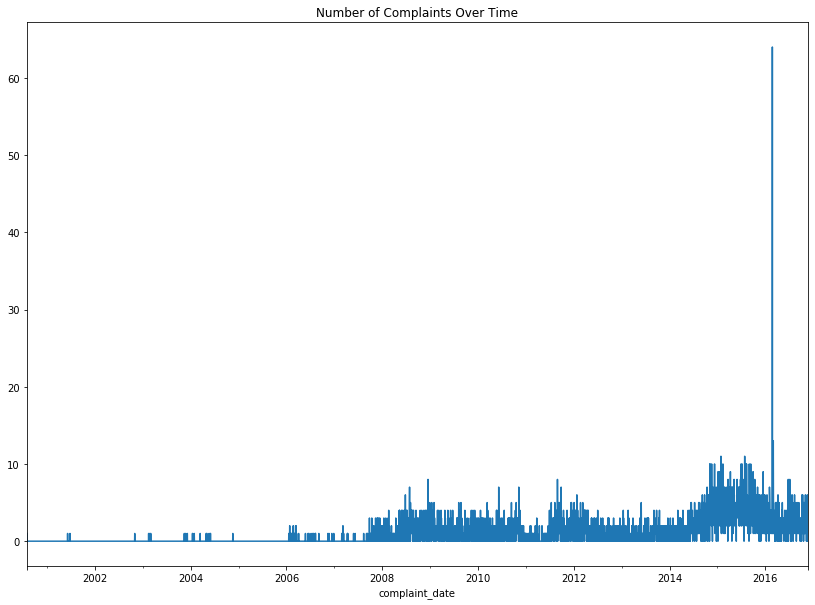

In [55]:
ca_complaints_df.index = ca_complaints_df['complaint_date']
ca_complaints_df.groupby([pd.Grouper(freq='D')]).count()['text'].plot(kind='line',
                                                                      figsize=(14,10),
                                                                     title='Number of Complaints Over Time')

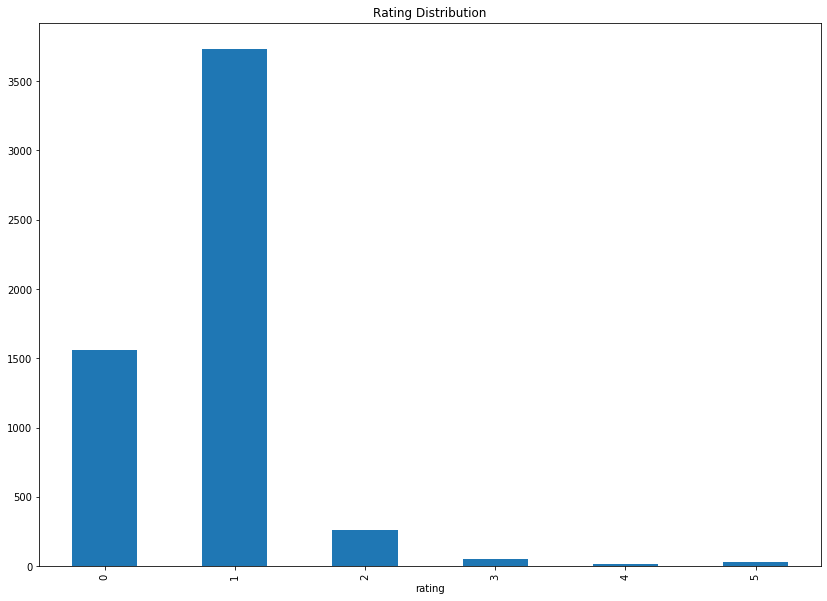

In [56]:
ca_complaints_df.groupby('rating').count()['author'].plot(kind='bar',
                                                          figsize=(14,10),
                                                          title='Rating Distribution')

[('service', 13715), ('tell', 7748), ('call', 7717), ('comcast', 6033), ('customer', 5666), ('time', 5602), ('say', 5203), ('phone', 4842), ('internet', 4780), ('month', 4724), ('pay', 4711), ('cable', 4390), ('bill', 3828), ('come', 3741), ('day', 3603), ('go', 3571), ('charge', 3432), ('get', 3381), ('work', 3234), ('problem', 3229), ('ask', 2551), ('hour', 2496), ('account', 2467), ('year', 2452), ('company', 2422), ('receive', 2418), ('try', 2316), ('new', 2243), ('send', 2128), ('box', 2123)]


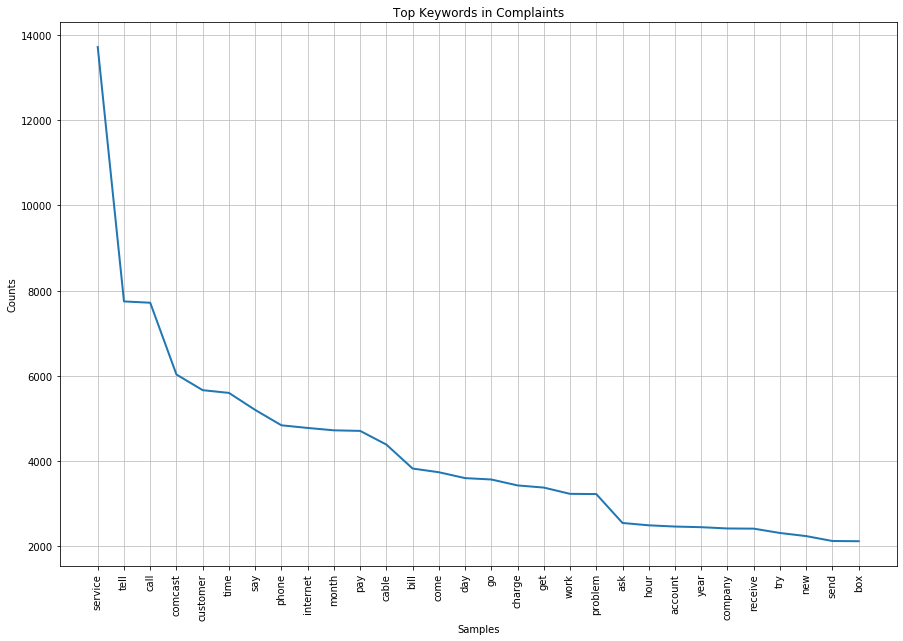

In [57]:
#convert to list
complaints_tokenized_processed = list(tokenize(complaints_lemmatized))
complaints_tokenized_fdist = [item for tokenized_complaint in complaints_tokenized_processed for item in tokenized_complaint]

#change figure size and change title
plt.figure(figsize=(15, 10))
plt.title("Top Keywords in Complaints")

#using fdist from nltk to find most common keywords
fdist = FreqDist(complaints_tokenized_fdist)
print(fdist.most_common(30))
fdist.plot(30)

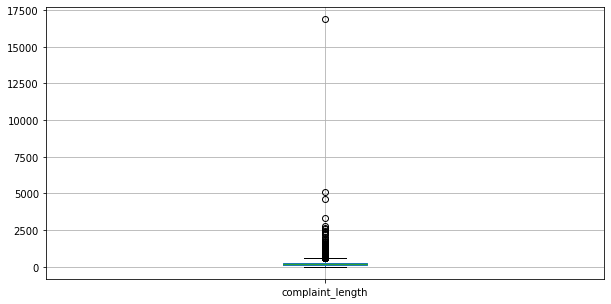

In [58]:
#boxplot with inital complaints
ca_complaints_df['complaint_length'] = ca_complaints_df['text'].str.split().str.len()
ca_complaints_df.boxplot(column='complaint_length',figsize=(10,5))

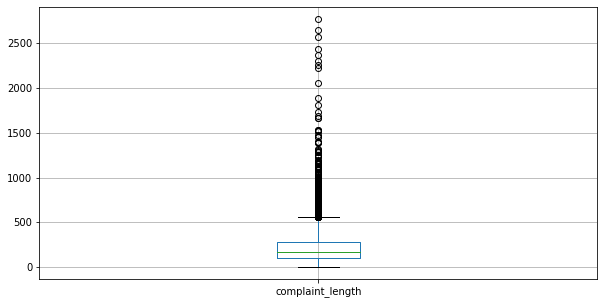

In [59]:
#removed very large outliers
ca_complaints_df[ca_complaints_df.complaint_length <3000].boxplot(column='complaint_length',figsize=(10,5))

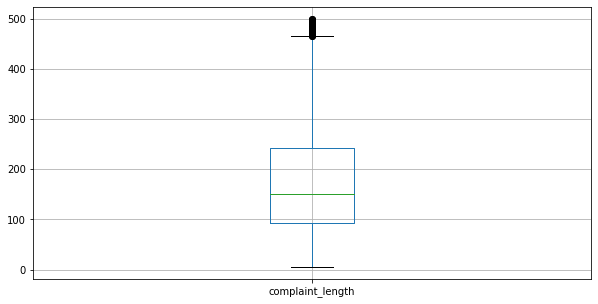

In [60]:
#removed outliers to show complaint length distribution
ca_complaints_df[ca_complaints_df.complaint_length <500].boxplot(column='complaint_length',figsize=(10,5))

# Baseline LDA Model Creation

### Strategy
Now that the data has been preprocessed and explored we will now create a first cut of the LDA model.

The intent of this is to create a baseline model and obtain a baseline Coherence value.

We will assume 5 latent topics for our initial model.

In [61]:
#create list of tokenized complaints
complaints = list(tokenize(complaints_lemmatized))

#Create dictionary object of for gensim
dictionary = Dictionary(complaints)

print('Distinct words in initial documents:', len(dictionary))

# Filter out words who dont occur within twenty complaints or words who are in 20% or more of complaints.
dictionary.filter_extremes(no_below=20, no_above=0.20)

print('Distinct tokens after removing rare and common words:', len(dictionary))

Distinct words in initial documents: 9402
Distinct tokens after removing rare and common words: 1506


In [74]:
#create complaints corpus
complaints_corpus = [dictionary.doc2bow(doc) for doc in complaints]

#initial number of topics
num_topics = 5

model = []

#generate lda and coherence model
model = gensim.models.LdaMulticore(corpus=complaints_corpus, num_topics=num_topics, id2word=dictionary, passes=20, workers=2,random_state=1)
coherencemodel = CoherenceModel(model=model, texts=complaints, dictionary=dictionary, coherence='c_v')

#obtain baseline coherence score
print('Coherence value of baseline model is: ', coherencemodel.get_coherence())

Coherence value of baseline model is:  0.4437746480855743


# Baseline LDA Model Results and Exploration

Now that we have constructed a baseline model, we can explore the results.

-The initial coherence score is 0.44 (rounded)
- From the 5 topics we can see below the top 15 keywords in each topic. 

Quick analysis of these keywords can possibly show the following themes.

| Topic Number | Possible Theme                         |
|--------------|----------------------------------------|
| 0            | Payments                      |
| 1            | Cable/Tv Problems                      |
| 2            | Fees                 |
| 3            | Contact Centre       |
| 4            | Credit |


We see great seperation between our topics as seen in pyLDAvis.

Our next steps will be execute the optimization strategy and find the best LDA Model based on coherence score.

In [75]:
for topic_num in range(model.num_topics):
     print('Topic '+ str(topic_num) +' '+ ", ".join([word for word, prop in model.show_topic(topic_num,topn=15)]))
        

Topic 0 payment, supervisor, voice, rewire, mail, signal, message, line, person, suppose, place, state, leave, approve, house
Topic 1 box, tech, tv, order, fix, home, install, show, line, wait, instal, appointment, dvr, set, leave
Topic 2 fee, price, package, channel, contract, offer, speed, rate, sign, change, tv, high, increase, cost, deal
Topic 3 number, supervisor, minute, speak, appointment, wait, hold, issue, transfer, home, contact, give, explain, representative, talk
Topic 4 credit, equipment, issue, money, return, people, find, bad, email, address, business, check, home, modem, move


In [76]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, complaints_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.080379 -0.021220       1        1  28.995312
3      0.018085 -0.103110       2        1  24.858717
2      0.101846  0.146828       3        1  23.810116
1      0.061280 -0.053485       4        1  17.683470
0     -0.261589  0.030987       5        1   4.652385, topic_info=           Term         Freq        Total Category  logprob  loglift
74          box  2340.000000  2340.000000  Default  30.0000  30.0000
442  supervisor  1947.000000  1947.000000  Default  29.0000  29.0000
667     payment   980.000000   980.000000  Default  28.0000  28.0000
263      number  2135.000000  2135.000000  Default  27.0000  27.0000
198          tv  1908.000000  1908.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
74          box   141.604935  2340.812500   Topic5  -4.4626   0.2626
198          tv   125.719765  1908.194824   Topic5  -4.5816   0.3479
504        card    96.128426   438.388855   Topic5  -4.8500   1.5504
262       modem   102.102165  1037.670898   Topic5  -4.7897   0.7490
233       today    98.693504  1032.500977   Topic5  -4.8236   0.7201

[352 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
33        1  0.585763  access
33        2  0.155923  access
33        3  0.172779  access
33        4  0.080068  access
33        5  0.004214  access
...     ...       ...     ...
988       2  0.126828  wiring
988       4  0.858525  wiring
200       1  0.843806    yard
200       2  0.008192    yard
200       4  0.147461    yard

[978 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 3, 2, 1])

# Model Refinement

Now that the baseline coherence value of 0.396 has been identified we can now fit multiple models of varying topic numbers and find the best model based on highest coherence value.

Strategy:
1. Build models varying number of topics from 2 to 20.
2. Record coherence value
3. Best model chosen will be the model with the highest coherence value.

### Warning
Running the next cell might take some time.

In [65]:
def find_best_lda_model(complaints = complaints,corpus = complaints_corpus,dictionary=dictionary,n_topic_start=2,n_topic_finish=20):
    '''
    This function will find the optimum number of topics using the metric of Coherence.
    
    The model with the highest coherence will reveal the optimum number of topics to fit.
    
    Parameters:
    complaints: complaints 
    dictionary: Gensim Dictionary
    corpus: Gensim Corpus
    n_topic_start: number of topics to start with
    n_topic_start: number of topics to finish with
    
    Returns:
    models = list of LDA models
    coherence_results = list of the coherence results form the models
    '''
    
    #
    
    coherence_results = []
    models = []
    
    for num_topics in range(n_topic_start,n_topic_finish+1):
            
            model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=20, workers=2,random_state=1)
            coherencemodel = CoherenceModel(model=model, texts=complaints, dictionary=dictionary, coherence='c_v')
            
            models.append(model)
            coherence_results.append(coherencemodel.get_coherence())
            
    return models,coherence_results
    



model_results,model_coherence = find_best_lda_model()

print(model_coherence)

[0.31906955708868645, 0.3518480869810436, 0.4163523374451372, 0.4437746480855743, 0.48446775353055976, 0.44452302228358354, 0.4289934437696928, 0.42207040096091103, 0.42806303104842636, 0.4162036985221098, 0.43380329960831143, 0.42988305065538496, 0.4328711160999557, 0.41417424613050086, 0.4127152282194332, 0.40614476620584217, 0.3998250480871622, 0.4027386095481388, 0.3940018705209547]


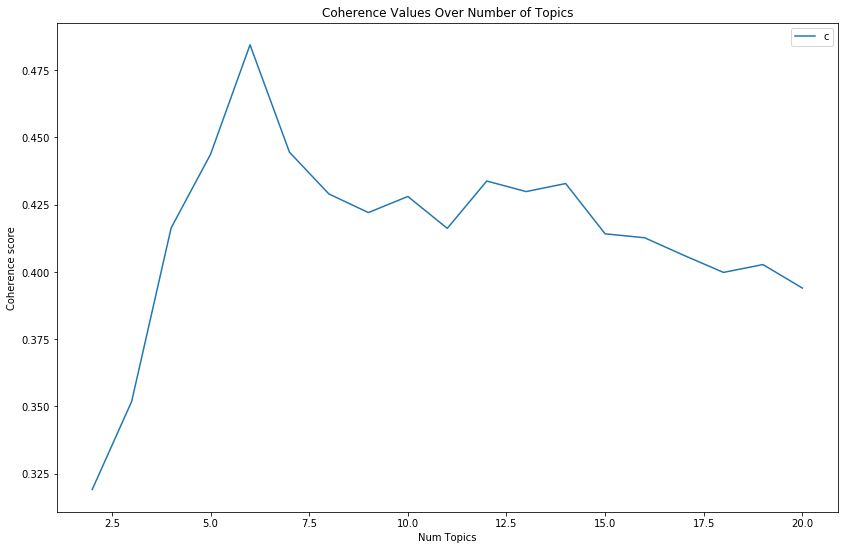

In [66]:
x = range(2,21, 1)
plt.figure(figsize=(14, 9))
plt.plot(x, model_coherence)

plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Coherence Values Over Number of Topics')
plt.show()

In [67]:
for m, cv in zip(x, model_coherence):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3191
Num Topics = 3  has Coherence Value of 0.3518
Num Topics = 4  has Coherence Value of 0.4164
Num Topics = 5  has Coherence Value of 0.4438
Num Topics = 6  has Coherence Value of 0.4845
Num Topics = 7  has Coherence Value of 0.4445
Num Topics = 8  has Coherence Value of 0.429
Num Topics = 9  has Coherence Value of 0.4221
Num Topics = 10  has Coherence Value of 0.4281
Num Topics = 11  has Coherence Value of 0.4162
Num Topics = 12  has Coherence Value of 0.4338
Num Topics = 13  has Coherence Value of 0.4299
Num Topics = 14  has Coherence Value of 0.4329
Num Topics = 15  has Coherence Value of 0.4142
Num Topics = 16  has Coherence Value of 0.4127
Num Topics = 17  has Coherence Value of 0.4061
Num Topics = 18  has Coherence Value of 0.3998
Num Topics = 19  has Coherence Value of 0.4027
Num Topics = 20  has Coherence Value of 0.394


In [73]:
optimal_model = model_results[4]

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(optimal_model, complaints_corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.032013  0.067555       1        1  22.491684
2     -0.102139 -0.135773       2        1  21.860790
4     -0.098099  0.031570       3        1  19.333138
3     -0.042010  0.129895       4        1  18.406780
1     -0.044955 -0.073083       5        1  14.986168
0      0.319216 -0.020164       6        1   2.921441, topic_info=            Term         Freq        Total Category  logprob  loglift
74           box  2269.000000  2269.000000  Default  30.0000  30.0000
442   supervisor  1979.000000  1979.000000  Default  29.0000  29.0000
73   appointment  1490.000000  1490.000000  Default  28.0000  28.0000
198           tv  1864.000000  1864.000000  Default  27.0000  27.0000
263       number  2183.000000  2183.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
472        order    96.720184  1415.976685   Topic6  -4.3785   0.8493
262        modem    91.348305  1037.610840   Topic6  -4.4357   1.1031
253         high    83.859665   804.283081   Topic6  -4.5212   1.2723
60         right    79.100449   710.794617   Topic6  -4.5796   1.3374
150        state    72.897408  1096.319458   Topic6  -4.6613   0.8224

[412 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
114       1  0.172967  able
114       2  0.125681  able
114       3  0.094572  able
114       4  0.431796  able
114       5  0.144347  able
...     ...       ...   ...
401       1  0.132636  wire
401       3  0.007652  wire
401       4  0.030608  wire
401       5  0.701440  wire
401       6  0.130085  wire

[1307 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 5, 4, 2, 1])

In [79]:
def create_topic_dist(corpus,model):
    '''
    This function will return a dataframe which contains the probability of the complaint belonging to each topic
    
    Parameters:
    corpus: list of tokenized complaints
    model: trained model to obtain topic probabilities
    
    Returns:
    Dataframe with complaints along topic probability matrix
    
    '''
    num_topics = optimal_model.num_topics
    num_complaints = len(corpus)
    
    topic_proba = []
    
    keys = range(num_topics)
    
    
    
    for complaint in corpus:
        
        topic_probs = model[complaint]
        topic_dict = {}
        
        for i in keys:
            topic_dict[i] = 0
        
        for topic_prob in topic_probs:
            topic_dict[topic_prob[0]] = topic_prob[1] 
        
        topic_proba.append(topic_dict)
    
    df = pd.DataFrame(topic_proba)
    
    df['Complaint'] = ca_complaints
    df['Dominant_Topic_Proba'] = df[[0,1,2,3,4,5]].max(axis=1)
    df['Dominant_Topic'] = df[[0,1,2,3,4,5]].idxmax(axis=1)
    df.columns = ['Topic 0','Topic 1','Topic 2','Topic 3','Topic 4','Topic 5','Complaint','Dominant_Topic_Probability','Dominant_Topic']
    
    return df
    
                       
prob_matrix = create_topic_dist(complaints_corpus,optimal_model)
prob_matrix.head()


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Complaint,Dominant_Topic_Probability,Dominant_Topic
0,0.000000,0.710796,0.000000,0.249618,0.000000,0.000000,I used to love Comcast. Until all these consta...,0.710796,1
1,0.070602,0.000000,0.452827,0.000000,0.000000,0.449995,I'm so over Comcast! The worst internet provid...,0.452827,2
2,0.000000,0.000000,0.512127,0.114502,0.339949,0.026266,If I could give them a negative star or no sta...,0.512127,2
3,0.142799,0.522911,0.131678,0.000000,0.000000,0.192435,I've had the worst experiences so far since in...,0.522911,1
4,0.000000,0.000000,0.848851,0.133842,0.000000,0.000000,Check your contract when you sign up for Comca...,0.848851,2


In [80]:
for topic_num in range(optimal_model.num_topics):
     print('Topic '+ str(topic_num) +' '+ ", ".join([word for word, prop in optimal_model.show_topic(topic_num,topn=15)]))



Topic 0 voice, supervisor, signal, rewire, message, line, house, mail, approve, suppose, person, place, leave, tv, box
Topic 1 box, tv, order, tech, fix, channel, dvr, watch, install, home, instal, wire, equipment, room, set
Topic 2 price, fee, package, contract, offer, channel, rate, sign, speed, change, high, increase, cost, tv, monthly
Topic 3 number, supervisor, speak, issue, transfer, minute, contact, state, representative, hold, help, request, talk, wait, explain
Topic 4 credit, payment, equipment, money, return, check, address, issue, find, collection, turn, cancel, move, refund, people
Topic 5 appointment, tech, home, wait, line, schedule, minute, show, connection, technician, fix, issue, modem, number, give


In [ ]:
#from the above we can determine the following themes

# Key: Topic Number 
# Value: Theme
topic_names = {0:'Voice',1:'Cable',2:'Pricing',3:'Contact Centre',4:'Payments',5:'Appointments'}

In [86]:

curdoc().theme = 'dark_minimal'


tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(prob_matrix[['Topic 0','Topic 1','Topic 2','Topic 3','Topic 4','Topic 5']].to_numpy())

theme = ["#5fad56","#f2c14e","#f78154","#4d9078","#b4436c","#f2efea","#fc7753","#66d7d1","#403d58","#dbd56e"]



tsne_df = pd.DataFrame()

tsne_df['Description'] = prob_matrix['Complaint']
tsne_df['X'] = X_tsne[:,0]
tsne_df['Y'] = X_tsne[:,1]
tsne_df['Dominant_Topic'] = prob_matrix['Dominant_Topic']
tsne_df['Colors'] = fcc_df_super['Dominant_Topic'].apply(lambda topic: theme[topic])

source = ColumnDataSource(dict(
    x=tsne_df['X'],
    y=tsne_df['Y'],
    color=tsne_df['Colors'],
    label=tsne_df['Dominant_Topic'].apply(lambda t: topic_names[t])))



title = 'T-SNE Visualization of Topics'
plot_tsne = figure(plot_width=1000, plot_height=600, title=title,
                   tools=['pan', 'wheel_zoom', 'save'])

plot_tsne.scatter(x='x', y='y', legend_field='label', source=source, color='color', alpha=0.6, size=5.0)
plot_tsne.legend.location = "top_right"

output_notebook()
show(plot_tsne)

Loading BokehJS ...

# Results


### Model Evaulation and Validation
From the strategy we have identified the best model utilizing 6 topics with a coherence score of ~0.48.

From the visuals produced by pyLDAvis as well as looking the T-SNE Visualisation and SVD visualisation we can see theeperation between topics as well as see complaints who share similar themes.

Relative to our baseline model we have seen in improvement from a metric perspective (greater coherence score).

### Justification
Looking at the top keywords of each topic, we can definitely see some major themes emerging. From the keywords discovered each topic can be interpreted with each theme. 

| Topic Number | Possible Theme |
|--------------|----------------|
| 0            | Voice          |
| 1            | Cable          |
| 2            | Pricing        |
| 3            | Contact Centre |
| 4            | Payments       |
| 5            | Appointments   |

These insights provide a good solution to our problem statement. 'What are the hidden topics'.

LDA has provided us with a method to obtain latent complaints topics over thousands of complaints.

We performed a trivial method of finding themes by just looking at the top key words of the entire corpus (Performed in the EDA section)

However the topics" and keywords revealed by LDA will be more useful to the business and provide a starting point for more deep diving on these themes.




# Conclusion

### Reflection

End to end we explored and implemented a proof of concept for discovering latent topics within customer complaints utilizing LDA.

This proof of concept can be further explored and utilized in a business context and shed further light in the world of customer complaints.

Step by Step Summary.

1. Complaints Data Pre Processed.
2. Pre Processed Data Initial EDA.
3. Baseline LDA model was obtained.
4. Refined LDA model was obtained by optimizing Coherence Score of model.
5. Topics keywords were analysed and possible themes determined.
6. Complaints visualised identifying complaints with multiple themes as well as complaints with distinct themes.

From here the business can take these insights, identify problems within the business that relate to this themes, action accordingly and finally improve the customer experience.


### Improvement

#### Stop Word List Improvement
An improved list of Stop Words can be implemented during the Pre Processing Stage. SME's can identify words common in Comcast complaints that will further develop the model reducing redundant keywords found in complants.

This will require personnel with heavy domain specific knowledge.